In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# 1.Data Preparation and Visualiazation

### 1.1 Read data

In [2]:
data = sio.loadmat("./ex8/ex8data1.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X = data["X"]
Xval,yval = data["Xval"], data["yval"]
print(X.shape,Xval.shape,yval.shape)

(307, 2) (307, 2) (307, 1)


### 1.2 Visualized data

In [4]:
def plot_data():
    fig,ax = plt.subplots(figsize = (7,5))
    ax.scatter(X[:,0],X[:,1],marker = "x",color = "b")
    ax.set(xlabel = "", ylabel = "") 

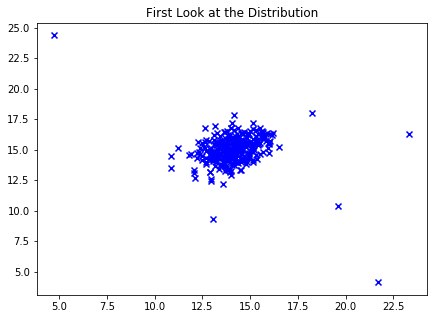

In [5]:
plot_data()
plt.title("First Look at the Distribution")
plt.show()

# 2.Model Inplementation
##### Here we have two senarios:
<ol>
    <li>Normal Gaussian Distribution Model - model each P(x) seperately</li>
    <li>Gaussian Mixed Model - model P(x) all in one go</li>
</ol>

### 2.1 Gaussian Function
##### We create one guassian function for both models

$$ P(x) = \frac{1}{(2\pi)^{1/2}\sigma}$$



In [28]:
def estimateGaussian(X,isCovariance):
    means = np.mean(X,axis = 0)
    if isCovariance:
        sigma2 = (X-means).T@(X-means)/len(X)
    else:
        sigma2 = np.var(X, axis = 0)
    return means, sigma2

In [29]:
means, sigma2 = estimateGaussian(X, isCovariance=True)
sigma2

array([[ 1.83263141, -0.22712233],
       [-0.22712233,  1.70974533]])

In [30]:
means,sigma2 = estimateGaussian(X,isCovariance=False)
sigma2

array([1.83263141, 1.70974533])

In [55]:
def gaussian(X,means,sigma2):
    if np.ndim(sigma2) ==1:
        sigma2 = np.diag(sigma2) #make 1d to 2d
    X = X - means
    n= X.shape[1]
    
    first = np.power(2*np.pi,-n/2) * (np.linalg.det(sigma2)**(-0.5))
    second = np.diag(X@np.linalg.inv(sigma2)@X.T)
    p = first * np.exp(-0.5*second)
    p = p.reshape(-1,1)
    return p
    

In [63]:
def plot_contours(X,mu,sigma2):
    x = np.arange(0, 30, 0.5)
    xx, yy = np.meshgrid(x,x)
    points = np.c_[xx.ravel(),yy.ravel()] #like pd.merge
    z = guassian(points, mu,sigma2)
    z = z.reshape(xx.shape)
    plt.plot(X[:,0],X[:,1],"bx")
    
    cont_levels = [10**h for h in range(-20,0,3)]
    plt.contour(xx,yy,z,cont_levels)
    plt.title("Gaussian Contours", fontsize =16)

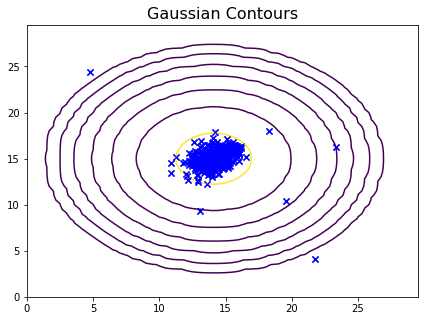

In [66]:
plot_data()
mu,sigma2 = estimateGaussian(X,False)
plot_contours(X,mu,sigma2)

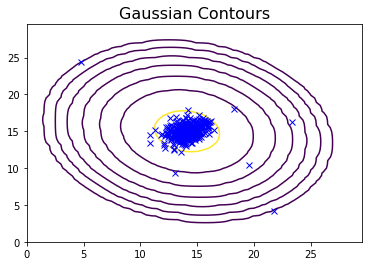

In [68]:
mu,sigma2 = estimateGaussian(X,True)
plot_contours(X,mu,sigma2)

### 2.2 Select threshold epsilon

In [69]:
def selectThreshold(yval,p):
    best_epsilon = 0
    best_f1 = 0
    epsilons = np.linspace(min(p), max(p), 1000)
    for e in epsilons:
        p_ = p < e # select all anomaly points
        tp = np.sum((yval == 1) & (p_ == 1))
        fp = np.sum((yval == 0) & (p_ == 1))
        fn = np.sum((yval == 0) & (p_ == 1))
        prec = tp/(tp+fp) if (tp+fp) else 0
        recall = tp/(tp+fn) if (tp+fn) else 0
        
        f1_e = 2 * prec*recall/(prec+recall) if (prec + recall) else 0 #calculate F1 score(harmonic mean)
        
        if f1_e > best_f1:
            best_f1 = f1_e
            best_epsilon = e
    return best_epsilon, best_f1

In [70]:
means, sigma2 = estimateGaussian(X,isCovariance =True)
pval = gaussian(Xval, means, sigma2) # the possilibity of each sample to be positive 
bestEpsilon, bestF1 = selectThreshold(yval, pval)

In [71]:
bestEpsilon,bestF1

(array([9.07484457e-05]), 1.0)

# 3. Model Evaluation

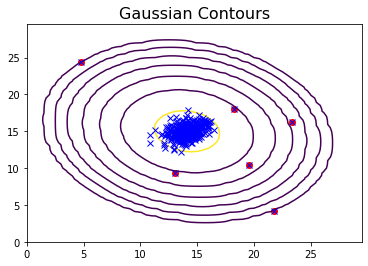

In [72]:
p = gaussian(X, means, sigma2)
anoms =np.array([X[i] for i in range(X.shape[0]) if p[i]< bestEpsilon])
plot_contours(X,means,sigma2)
plt.scatter(anoms[:,0], anoms[:,1],c = "r", marker = "o")

# 4. Practice - High dimensional case

In [77]:
data = sio.loadmat(".\ex8\ex8data2.mat")
X2 = data["X"]
Xval2,yval2 = data["Xval"],data["yval"]
X2.shape

(1000, 11)

In [85]:
means,sigma2 =estimateGaussian(X2,isCovariance=True)

In [86]:
means, sigma2

(array([  4.93940034,  -9.63726819,  13.81470749, -10.4644888 ,
         -7.95622922,  10.19950372,  -6.01940755,   7.96982896,
         -6.2531819 ,   2.32451289,   8.47372252]),
 array([[60.97489373,  1.31326798,  0.69281764,  0.13023346,  4.67650614,
         -0.5319865 , -3.3787425 ,  4.941811  , -1.15413737,  3.91246837,
         -2.9035848 ],
        [ 1.31326798, 53.20572186, -2.22465574, -4.60617258,  1.73297959,
          3.0795527 ,  1.38344891,  7.51296644,  4.19433575, -4.82545562,
          7.71463779],
        [ 0.69281764, -2.22465574, 58.51546272,  2.62369834,  3.30837232,
         -3.38774814,  2.84626878,  2.17552083,  7.22855319,  5.88898076,
         -2.84657216],
        [ 0.13023346, -4.60617258,  2.62369834, 84.20403725,  1.90528898,
          1.42692461,  3.7630967 ,  2.56814574, -4.17828989,  1.91242699,
         -1.23112586],
        [ 4.67650614,  1.73297959,  3.30837232,  1.90528898, 65.26859177,
          1.18315364,  5.4095264 , -2.52378584,  0.74683447,  

In [87]:
pval = gaussian(Xval2,means,sigma2)
bestEpsilon, bestF1 = selectThreshold(yval2,pval)
p = guassian(X2,means,sigma2)
anoms=[X2[i] for i in range(len(X2)) if p[i]< bestEpsilon]
len(anoms)

122